In [1]:
import os
import numpy as np
os.chdir('/import/home2/yhchenmath/Code/ucs/')
# No warning
import warnings
import tifffile
import h5py
from skimage.segmentation import find_boundaries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn
warnings.filterwarnings('ignore')
from downstream.utils import read_json_to_namespace

config = read_json_to_namespace("./downstream/config/xenium_breast_cancer.json")

# Mask
method_list = ["UCS_10X","Nuclei_10X", "Cell_10X", "BIDCell", "Baysor"]

In [2]:
# Load mask and csv/anndata1
import tifffile
import pandas as pd
import scanpy as sc
from skimage.segmentation import find_boundaries

mask_dict = {}
df_dict = {}
ad_st_dict = {}
boundary_dict = {}
for method in method_list:
    mask = tifffile.imread(config.segmentation_results[method])
    df = pd.read_csv(os.path.join(config.output_dir, f"{method}_cell_feature.csv"), index_col=0)
    ad_st = sc.read_h5ad(f"{config.output_dir}/scVI_output/{method}/annotated_adata_st.h5ad")
    mask_dict[method] = mask
    boundary_dict[method] = find_boundaries(mask, mode='inner')
    df_dict[method] = df
    ad_st_dict[method] = ad_st

In [3]:
# Load other
he = tifffile.imread(config.he)
dapi = tifffile.imread(config.dapi)

gene_map = tifffile.imread(config.gene_map)
gene_map_sum = gene_map.sum(axis=2)
with open(config.gene_names, 'r') as f:
    gene_names = f.readlines()
gene_names = [x.strip() for x in gene_names]

## Plot

In [4]:
method_nuclei_dict = {
    "UCS_10X": "Nuclei_Cellpose",
    "Cell_10X": "Nuclei_Cellpose",
    "UCS SM+Marker": "Nuclei_Cellpose",
    "UCS_Cellpose": "Nuclei_Cellpose",
    "BIDCell": "Nuclei_Cellpose",
    "Baysor": "Nuclei_Cellpose"
}
nuclei_df = pd.DataFrame(index=method_nuclei_dict.keys(), columns=np.unique(ad_st_dict["UCS_10X"].obs["C_scANVI"]))
cell_df = pd.DataFrame(index=method_nuclei_dict.keys(), columns=np.unique(ad_st_dict["UCS_10X"].obs["C_scANVI"]))

In [5]:
x = "Nuclei_Cellpose"
ad_nuclei = sc.read_h5ad(f"{config.output_dir}/scVI_output/{x}/annotated_adata_st_with_ecc.h5ad")
nuclei_cell = {}
for y in cell_df.columns:
    y_nuclei = ad_nuclei.obs.loc[ad_nuclei.obs["C_scANVI"] == y, "elongate_y"]
    x_nuclei = ad_nuclei.obs.loc[ad_nuclei.obs["C_scANVI"] == y, "elongate_x"]
    scale_nuclei = x_nuclei / y_nuclei
    scale_nuclei = scale_nuclei.dropna()
    scale_nuclei = scale_nuclei[scale_nuclei != 0]
    nuclei_cell[y] = scale_nuclei.mean()

In [6]:
for x in cell_df.index:
    for y in cell_df.columns:
        # ad_nuclei = sc.read_h5ad(f"/import/home2/yhchenmath/Log/CellSeg/result_collection/xenium_breast_cancer/scVI_output/{method_nuclei_dict[x]}/annotated_adata_st_shape.h5ad")
        ad_cell = sc.read_h5ad(f"{config.output_dir}/scVI_output/{x}/annotated_adata_st_with_ecc.h5ad")
        # y_nuclei = ad_nuclei.obs.loc[ad_nuclei.obs["C_scANVI"] == y, "elongate_y"]
        # x_nuclei = ad_nuclei.obs.loc[ad_nuclei.obs["C_scANVI"] == y, "elongate_x"]
        y_cell = ad_cell.obs.loc[ad_cell.obs["C_scANVI"] == y, "elongate_y"]
        x_cell = ad_cell.obs.loc[ad_cell.obs["C_scANVI"] == y, "elongate_x"]

        # scale_nuclei = x_nuclei / y_nuclei
        scale_cell = x_cell / y_cell
        scale_cell = scale_cell.dropna()
        scale_cell = scale_cell[scale_cell != 0]
        nuclei_df.loc[x, y] = nuclei_cell[y]
        cell_df.loc[x, y] = scale_cell.mean()

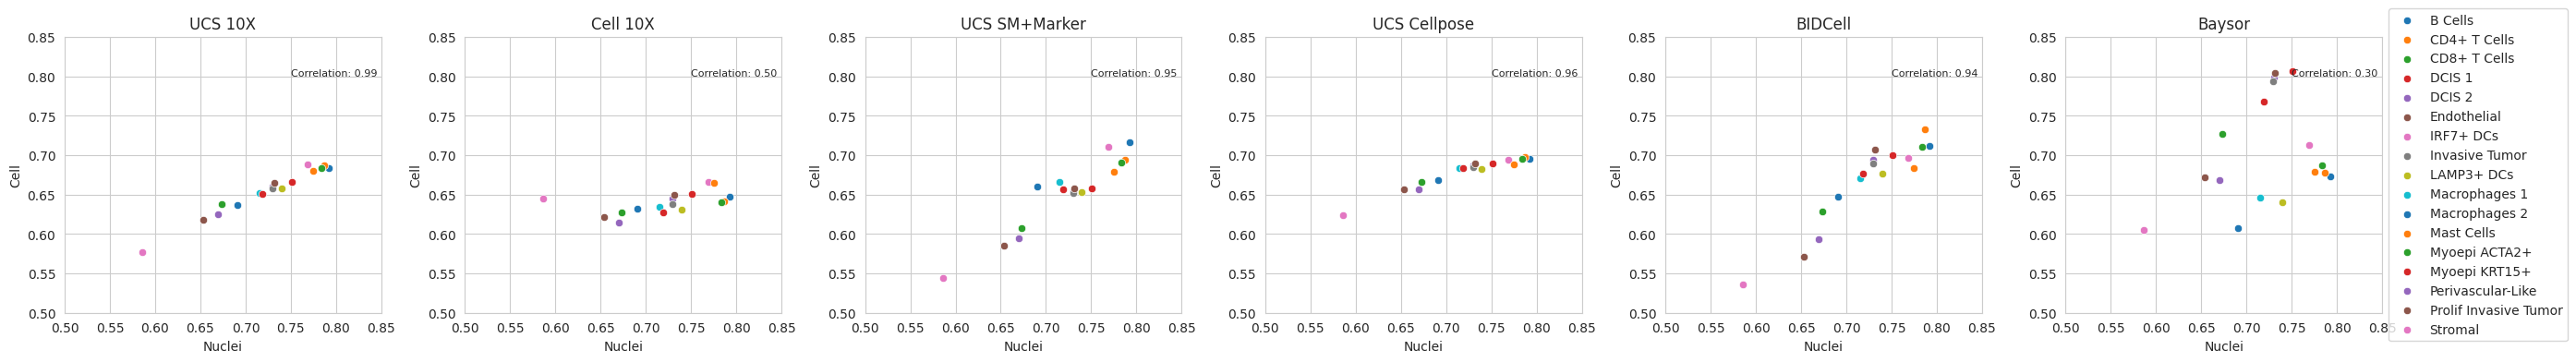

In [7]:
# Scatter plot of elongation: x: nuclei, y: cell, different color for different cell type
import seaborn as sns
# sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 6, figsize=(28, 4))
for i, method in enumerate(nuclei_df.index):
    for j, cell_type in enumerate(nuclei_df.columns):
        sns.scatterplot(x=[nuclei_df.loc[method, cell_type]], y=[cell_df.loc[method, cell_type]], ax=ax[i], label=cell_type)
    ax[i].set_title(method.replace("_", " "))
    ax[i].set_xlabel("Nuclei")
    ax[i].set_ylabel("Cell")
    # Only legend 1 time and put on the right
    if i == len(nuclei_df.index) - 1:
        ax[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax[i].get_legend().remove()
    # Lim: 0.5 - 0.9
    ax[i].set_ylim(0.5, 0.85)
    ax[i].set_xlim(0.5, 0.85)
    # Correlation
    ax[i].text(0.75, 0.8, f"Correlation: {cell_df.loc[method].corr(nuclei_df.loc[method]):.2f}", fontsize=8)
    plt.tight_layout()

In [8]:
# Fibroblast
stromal_nuclei_dict = {}
stromal_cell_dict = {}
method_nuclei_dict = {
    "UCS_10X": "Nuclei_10X",
    "Cell_10X": "Nuclei_10X",
    "UCS SM+Marker": "Nuclei_Cellpose",
    "UCS_Cellpose": "Nuclei_Cellpose",
    "BIDCell": "Nuclei_Cellpose"
}
for x in method_nuclei_dict.keys():
    ad_nuclei = sc.read_h5ad(f"{config.output_dir}/scVI_output/{method_nuclei_dict[x]}/annotated_adata_st_with_ecc.h5ad")
    ad_cell = sc.read_h5ad(f"{config.output_dir}/scVI_output/{x}/annotated_adata_st_with_ecc.h5ad")
    y_nuclei = ad_nuclei.obs.loc[ad_nuclei.obs["C_scANVI"] == "Stromal", "elongate_y"]
    x_nuclei = ad_nuclei.obs.loc[ad_nuclei.obs["C_scANVI"] == "Stromal", "elongate_x"]
    y_cell = ad_cell.obs.loc[ad_cell.obs["C_scANVI"] == "Stromal", "elongate_y"]
    x_cell = ad_cell.obs.loc[ad_cell.obs["C_scANVI"] == "Stromal", "elongate_x"]
    scale_nuclei = x_nuclei / y_nuclei
    scale_cell = x_cell / y_cell
    stromal_nuclei_dict[x] = scale_nuclei.dropna()
    stromal_cell_dict[x] = scale_cell.dropna()
    # Drop 0
    stromal_nuclei_dict[x] = stromal_nuclei_dict[x][stromal_nuclei_dict[x] != 0]
    stromal_cell_dict[x] = stromal_cell_dict[x][stromal_cell_dict[x] != 0]
    # Only take the index intersection
    stromal_nuclei_dict[x] = stromal_nuclei_dict[x][stromal_nuclei_dict[x].index.isin(stromal_cell_dict[x].index)]
    stromal_cell_dict[x] = stromal_cell_dict[x][stromal_cell_dict[x].index.isin(stromal_nuclei_dict[x].index)]

Text(0, 0.5, 'Cell')

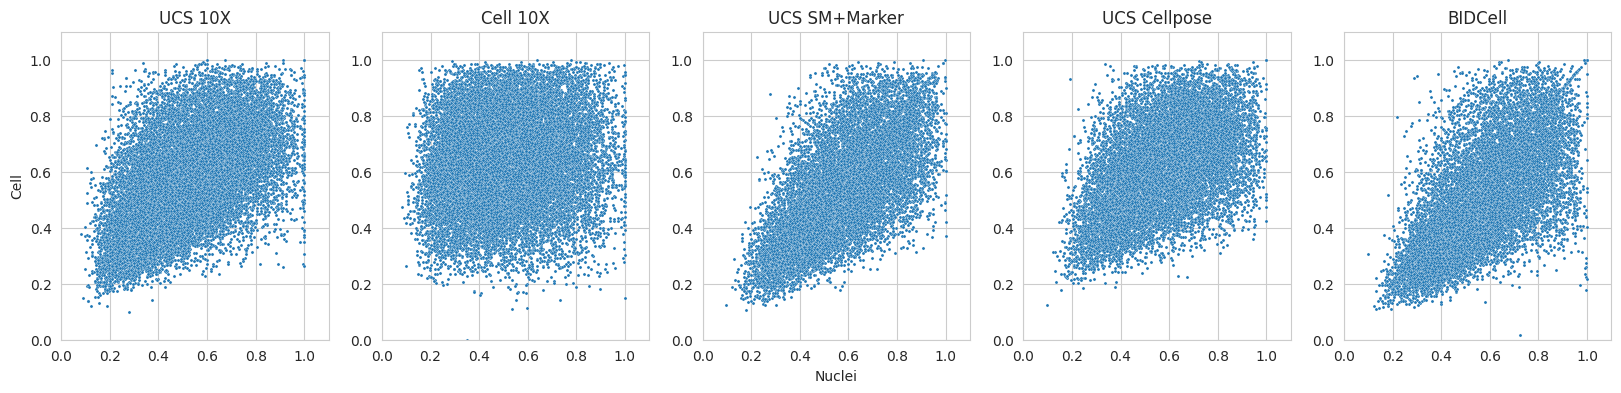

In [10]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))
for i, key in enumerate(stromal_nuclei_dict.keys()):
    # Scatter plot
    sns.scatterplot(x=stromal_nuclei_dict[key], y=stromal_cell_dict[key], ax=ax[i], s=5)
    ax[i].set_title(key.replace("_", " "))

    # Lim 0 - 1.1
    ax[i].set_ylim(0, 1.1)
    ax[i].set_xlim(0, 1.1)

ax[2].set_xlabel("Nuclei")
ax[0].set_ylabel("Cell")